## 328 - Animating Skew-T and CAPE Time Series

[Youtube](https://www.youtube.com/watch?v=1pFKt_RJ20Y)

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from metpy.plots import SkewT
from metpy.calc import parcel_profile, lcl, cape_cin, get_layer
from metpy.units import units, pandas_dataframe_to_unit_arrays
import pandas as pd
from siphon.simplewebservice.wyoming import WyomingUpperAir
import math
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
from matplotlib.dates import DayLocator, DateFormatter
import numpy as np

In [2]:
def get_data(station, date):
    """
    Gets data for a station from Wyoming upper air and computes derived parameters.
    """
    try:
        data = WyomingUpperAir.request_data(date, station)
        df_units = data.units
        data = data.dropna(subset=['pressure', 'temperature', 'dewpoint'])
        data = pandas_dataframe_to_unit_arrays(data, df_units)
        data['parcel_prof'] = parcel_profile(data['pressure'], data['temperature'][0], data['dewpoint'][0].to('degC'))
        cape, _ = cape_cin(data['pressure'], data['temperature'], data['dewpoint'], data['parcel_prof'])
        return data, cape
    except ValueError as e:
        print(f'Skipping {station} on {date} - {e}')
        return None, None

In [3]:
station = 'OUN'
start_date = datetime(2024, 5, 14, 0)
ndays = 10

In [4]:
capes = []
soundings = []
dates = []
for i in range(2 * ndays):
    date = start_date + timedelta(hours=i * 12)
    print(f'Getting {date}')
    d, c = get_data(station, date)
    if d:
        capes.append(c.m)
        dates.append(date)
        soundings.append(d)

Getting 2024-05-14 00:00:00
Getting 2024-05-14 12:00:00
Getting 2024-05-15 00:00:00
Getting 2024-05-15 12:00:00
Getting 2024-05-16 00:00:00
Getting 2024-05-16 12:00:00
Skipping OUN on 2024-05-16 12:00:00 - No data available for 2024-05-16 12Z for station OUN.
Getting 2024-05-17 00:00:00
Getting 2024-05-17 12:00:00
Getting 2024-05-18 00:00:00
Getting 2024-05-18 12:00:00
Getting 2024-05-19 00:00:00
Getting 2024-05-19 12:00:00
Getting 2024-05-20 00:00:00
Getting 2024-05-20 12:00:00
Getting 2024-05-21 00:00:00
Getting 2024-05-21 12:00:00
Getting 2024-05-22 00:00:00
Getting 2024-05-22 12:00:00
Getting 2024-05-23 00:00:00
Getting 2024-05-23 12:00:00


In [5]:
def update(i, station, dates, sounding_data, capes, cape_line):
    """
    Update the dynamic skew-T multi panel plot
    """
    data = sounding_data[i]

    # Remove old data from plot
    for line in skew.ax.get_lines():
        line.remove()

    for coll in skew.ax.collections:
        coll.remove()

    # Plot new data
    skew.ax.set_title(f'{station} {dates[i]:%Y-%m-%d %HZ}')
    skew.plot(data['pressure'], data['temperature'], 'tab:red')
    skew.plot(data['pressure'], data['dewpoint'], 'tab:green')
    skew.plot(data['pressure'], data['parcel_prof'], 'k')

    sounding_depth = np.max(data['pressure']) - np.min(data['pressure'])
    wind_layer = get_layer(data['pressure'], data['u_wind'], data['v_wind'], depth=min([sounding_depth.m, 850]) * units.hPa)
    skew.plot_barbs(wind_layer[0][::5], wind_layer[1][::5], wind_layer[2][::5])

    # Update CAPE time series
    cape_line.set_data(dates[:i+1], capes[:i+1])
    ax2.relim()
    ax2.autoscale_view(scaley = False)
    return cape_line, 

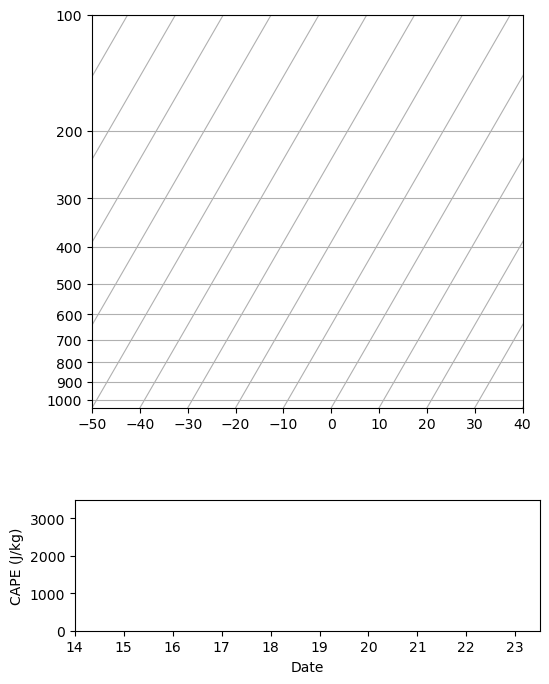

In [6]:
fig = plt.figure(figsize=(6, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.35)

skew = SkewT(fig, subplot=gs[0])

skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-50, 40)

max_cape_rounded = math.ceil(max(capes) / 500) * 500

ax2 = fig.add_subplot(gs[1])
cape_line, = ax2.plot([], [], 'o-')
ax2.set_ylabel('CAPE (J/kg)')
ax2.set_xlabel('Date')
ax2.set_xlim(dates[0], dates[-1])
ax2.set_ylim(0, max_cape_rounded)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax2.xaxis.set_major_locator(DayLocator())

In [7]:
ani = FuncAnimation(fig, update, frames=len(dates), interval=800, fargs=(station, dates, soundings, capes, cape_line))

ani.save('skewt_animation.mp4', writer='ffmpeg', fps=2)